in this notebook: downscale the era5land temperatures to the 4 time-series per cell (using lapse rate) 
(take a mean elevation for each of the cells, create new 4 time-series)

create new-time-series with cellnr + a/b/c/d/ 

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os

Text(0.5, 1.0, 'era5land grid')

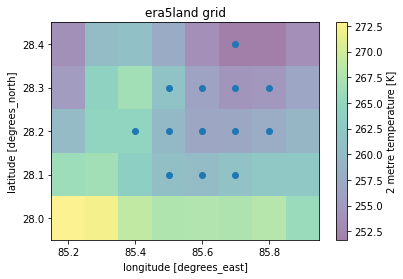

In [3]:
# test era5 land file
era5land = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/Era5/langtang/temp/2022.nc')
# era5land = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/Era5/bagrot/temp/2022.nc')
# era5land = xr.open_dataset('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/Era5/mustang/temp/2022.nc')



# csv with coordinates and geopotential (z) 
elevation = pd.read_csv('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/elevation/geopotential_langtang.csv')
# elevation = pd.read_csv('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/elevation/geopotential_mustang.csv')
# elevation = pd.read_csv('/Users/varyabazilova/Desktop/paper2/Thesisfiles_Varya/climate/elevation/geopotential_bagrot2.csv')

# plot together to see how points look
era5land.t2m.isel(time = 1).plot(alpha = 0.5)
plt.scatter(x = elevation.Longitude, y = elevation.Latitude)
plt.title('era5land grid')

In [4]:
elevation.columns

Index(['cellnr', 'Latitude', 'Longitude', 'z'], dtype='object')

In [5]:
# langtang_elevation

In [6]:
# dem 30m
# langtang dem - alluvial fans dem part 9
dempath = '/Users/varyabazilova/Desktop/alluvial_fans/dem_all/new_points_catchmetns/all_points/1_dem/'

dem_hma = xr.open_dataset(dempath + 'dem_clip.tif')
# clip using the langtang-ish bbox

# lon = x 
min_lon = era5land.longitude.values.min() - 0.05
max_lon = era5land.longitude.values.max() + 0.05

# lat = y
min_lat = era5land.latitude.values.min() - 0.05
max_lat = era5land.latitude.values.max() + 0.05

dem = dem_hma.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)


Text(0.5, 1.0, 'era5 land and dem together')

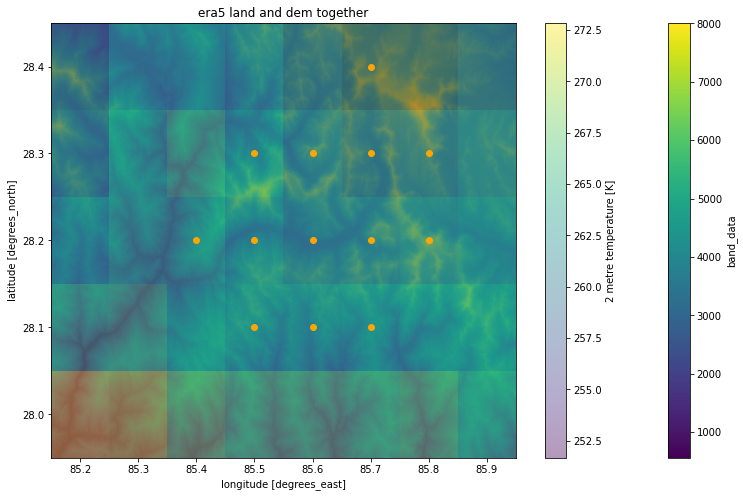

In [7]:
# plot dem together with points 
plt.figure(figsize = (13, 8))


dem.band_data.plot()
era5land.t2m.isel(time = 1).plot(alpha = 0.4)
plt.scatter(x = elevation.Longitude, y = elevation.Latitude, color = 'orange')

plt.title('era5 land and dem together')

## calculate the mean dem value per era5land pixel - xr.coarsen()

In [8]:
lat_len = len(era5land.latitude.values) *2 # y
lon_len = len(era5land.longitude.values) *2# x 

y_len = len(dem.y.values)
x_len = len(dem.x.values)

coarsened_dem = dem.coarsen(x=int(x_len/lon_len), y=int(y_len/lat_len), boundary='trim').median()

Text(0.5, 1.0, 'coarsened dem + era5 grid -> do they match?')

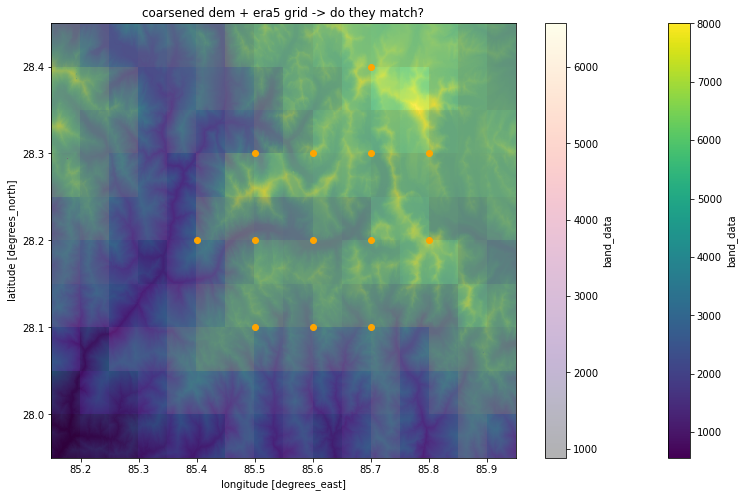

In [9]:
# plot all together to see of the grid matches

plt.figure(figsize = (13, 8))
dem.band_data.plot()
# era5land.t2m.isel(time = 1).plot(alpha = 0.3)
coarsened_dem.band_data.plot(cmap = 'magma', alpha = 0.3)
plt.scatter(x = elevation.Longitude, y = elevation.Latitude, color = 'orange')

plt.title('coarsened dem + era5 grid -> do they match?')

## make new points to get elevation from coarsened DEM 

In [10]:

df = elevation[['Longitude', 'Latitude']]

# Function to generate coordinates of 4 points around the middle of a square
def generate_points(row):
    x = row['Longitude']
    y = row['Latitude']
    points = [(x-0.025, y-0.025), (x+0.025, y-0.025), (x-0.025, y+0.025), (x+0.025, y+0.025)]  
    # Assuming each point represents the middle of a square and generate corners
    return pd.Series(points)

# Apply the function to each row
new_points = df.apply(generate_points, axis=1)

# Combine
result = pd.concat([df, new_points], axis=1)
result = result.melt(id_vars=['Longitude', 'Latitude'], value_name='point').drop(columns='variable')
result[['Longitude_new', 'Latitude_new']] = pd.DataFrame(result['point'].tolist(), index=result.index)

# Remove the original point
result = result[result['Longitude_new'] != result['Longitude']]
result = result[result['Latitude_new'] != result['Latitude']]

result

,Longitude,Latitude,point,Longitude_new,Latitude_new
0,85.500000,28.100000,"(85.475, 28.075000000000003)",85.475000,28.075000
1,85.599998,28.100000,"(85.574998, 28.075000000000003)",85.574998,28.075000
2,85.699997,28.100000,"(85.67499699999999, 28.075000000000003)",85.674997,28.075000
3,85.400002,28.200001,"(85.375002, 28.175001)",85.375002,28.175001
4,85.500000,28.200001,"(85.475, 28.175001)",85.475000,28.175001
5,85.599998,28.200001,"(85.574998, 28.175001)",85.574998,28.175001
6,85.699997,28.200001,"(85.67499699999999, 28.175001)",85.674997,28.175001
7,85.800003,28.200001,"(85.775003, 28.175001)",85.775003,28.175001
8,85.500000,28.299999,"(85.475, 28.274999)",85.475000,28.274999
9,85.599998,28.299999,"(85.574998, 28.274999)",85.574998,28.274999


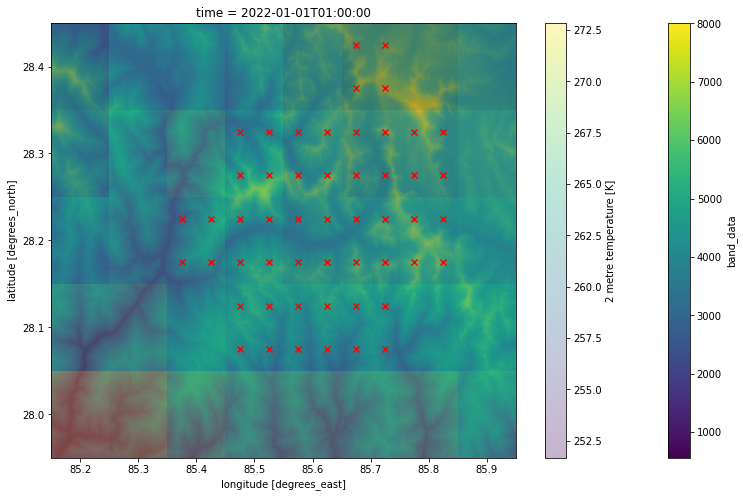

In [11]:
# plot all together to see of the grid matches

plt.figure(figsize = (13, 8))
dem.band_data.plot()
era5land.t2m.isel(time = 1).plot(alpha = 0.3)
# coarsened_dem.band_data.plot(cmap = 'magma', alpha = 0.3)
# plt.scatter(x = langtang_elevation.Longitude, y = langtang_elevation.Latitude, color = 'orange')
plt.scatter(x = result.Longitude_new, y = result.Latitude_new, marker = 'x', color = 'red')


In [12]:
result = result.merge(elevation, on = ['Longitude', 'Latitude'])

In [18]:
# result

## make unique cellnr (Na/b/c/d)

In [19]:
label = result[['cellnr']]

def generate_labels(row):
    return ['a', 'b', 'c', 'd']

 # Generate labels for each group of 4 rows
labels = label.groupby('cellnr').apply(generate_labels).explode().reset_index(drop=True)

result['labels'] = labels
result['cellnr2'] = result['cellnr'].astype(str) + labels

In [20]:
# result

In [21]:
# result.to_csv('coordinates_with_labels_bagrot.csv', index = False)
# result.to_csv('coordinates_with_labels_mustang.csv', index = False)

## locate a b c and d points

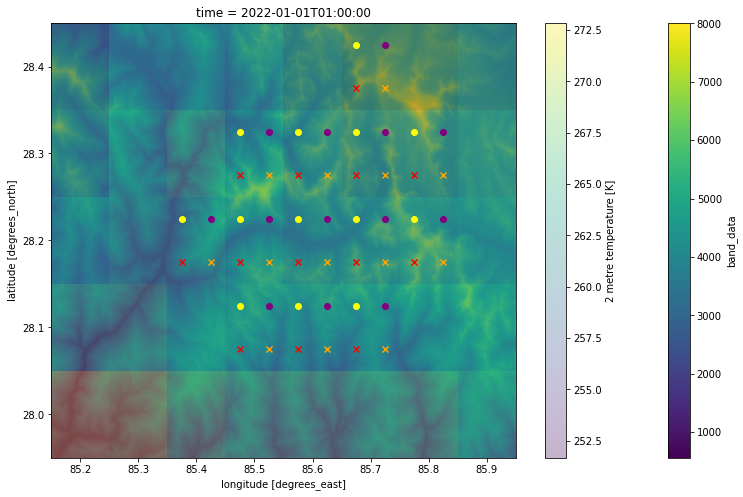

In [22]:
# only pick a points 
a  = result[result['labels'] == 'a']
b  = result[result['labels'] == 'b']
c  = result[result['labels'] == 'c']
d  = result[result['labels'] == 'd']


plt.figure(figsize = (13, 8))
dem.band_data.plot()
era5land.t2m.isel(time = 1).plot(alpha = 0.3)
plt.scatter(x = a.Longitude_new, y = a.Latitude_new, marker = 'x', color = 'red', label = 'a')
plt.scatter(x = b.Longitude_new, y = b.Latitude_new, marker = 'x', color = 'orange', label = 'b')
plt.scatter(x = c.Longitude_new, y = c.Latitude_new, marker = 'o', color = 'yellow', label = 'c')
plt.scatter(x = d.Longitude_new, y = d.Latitude_new, marker = 'o', color = 'purple', label = 'd')

# plt.legend()

## extract new elevation from DEM 

In [20]:
# langtang elevation - csv with z value for the geopotential 
longitudes = result.Longitude_new
latitudes = result.Latitude_new

selected = coarsened_dem.sel(x = longitudes, y = latitudes, method = 'nearest')

df = selected.to_dataframe()
df = df.reset_index()
df = df.drop_duplicates()
df = df.rename(columns = {'x':'Longitude_new', 'y':'Latitude_new'})

# # round so that coordinates match
result = result.round(3)
df = df.round(3)

In [21]:
merged = result.merge(df, on = ['Longitude_new', 'Latitude_new'])

# z - geopotential 
# band_data = dem data 
# delts H = difference between geopotential and DEM info
merged['delta_H'] = merged.z - merged.band_data 
merged['delta_t'] = merged.delta_H * 6.5/1000

In [23]:
# merged

In [24]:
# merged.to_csv('coordinates_and_elevation_with_labels_mustang.csv', index = False)

In [20]:
# final table with cell number and delta temperature 

df = merged[['cellnr','cellnr2', 'delta_t']]


In [21]:
# df

### downscale the temperatures for each file as input

In [22]:
# %%time

# # Specify the path to the folder containing climate files
# # climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2'
# climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate'

# # Step 1: Read the table data into a DataFrame
# table_df = df

# # Step 2: Iterate over each row in the DataFrame
# for index, row in table_df.iterrows():
#     cellnr = row['cellnr']
#     delta_t = row['delta_t']
#     cellnr2 = row['cellnr2']  # New column for generating filenames
    
#     # Step 3: Read and update the corresponding file
#     file_path = os.path.join(climate_folder, f'climatecell.{cellnr}.met')
#     if os.path.exists(file_path):
#         # Read the file into a DataFrame
#         file_df = pd.read_csv(file_path)
        
#         # Update Ta values for each group of four lines
#         for i in range(0, len(file_df), 4):
#             file_df.loc[i:i+3, 'Ta'] += delta_t
            
#         # Save the updated DataFrame back to the file with appropriate filename
#         new_file_path = os.path.join(climate_folder, f'climatefile.{cellnr2}.met')
#         file_df.to_csv(new_file_path, index=False)
#         print(f'Ta values updated and saved for {new_file_path}')
#     else:
#         print(f'File {file_path} not found.')

# print('All updates complete.')


In [23]:
# %%time

# # Specify the path to the folder containing climate files
# # climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2'
# climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate'

# # Step 1: Read the table data into a DataFrame
# table_df = df

# # Step 2: Iterate over each row in the DataFrame
# for index, row in table_df.iterrows():
#     cellnr = row['cellnr']
#     delta_t = row['delta_t']
#     cellnr2 = row['cellnr2']  # New column for generating filenames
    
#     # Step 3: Read and update the corresponding file
#     file_path = os.path.join(climate_folder, f'climatecell.{cellnr}.met')
#     if os.path.exists(file_path):
#         # Read the file into a DataFrame
#         file_df = pd.read_csv(file_path)
#         print(file_path)
        
#         # Update Ta values for each group of four lines
#         for i in range(0, len(file_df), 4):
#             file_df.loc[i:i+3, 'Ta'] += delta_t
            
#         # Save the updated DataFrame back to the file with appropriate filename
#         new_file_path = os.path.join(climate_folder, f'climatefile.{cellnr2}.met')
#         file_df.to_csv(new_file_path, index=False)
#         print(f'Ta values updated and saved for {new_file_path}')
#     else:
#         print(f'File {file_path} not found.')

# print('All updates complete.')


In [24]:
%%time
import os
import pandas as pd

# Specify the path to the folder containing climate files
# climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/langtang_climate2'
# climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/mustang_climate'
climate_folder = '/Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate'

# Step 1: Read the table data into a DataFrame
table_df = df

# Step 2: Iterate over each row in the DataFrame
for index, row in table_df.iterrows():
    cellnr = row['cellnr']
    delta_t = row['delta_t']
    cellnr2 = row['cellnr2']  # New column for generating filenames
    
    # Step 3: Read and update the corresponding file
    file_path = os.path.join(climate_folder, f'climatecell.{cellnr}.met')
    if os.path.exists(file_path):
        # Read the file into a DataFrame
        file_df = pd.read_csv(file_path)
        
        # Update Ta values for each group of four lines
        for i in range(0, len(file_df), 4):
            file_df.loc[i:i+3, 'Ta'] += delta_t
            
        # Create the folder 'cellnr2' if it doesn't exist
        save_folder = os.path.join(climate_folder, cellnr2)
        os.makedirs(save_folder, exist_ok=True)
        
        # Save the updated DataFrame to the file within the 'cellnr2' folder
        new_file_path = os.path.join(save_folder, f'climatefile.{cellnr2}.met')
        file_df.to_csv(new_file_path, index=False)
        print(f'Ta values updated and saved for {new_file_path}')
    else:
        print(f'File {file_path} not found.')

print('All updates complete.')


File /Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate/climatecell.21.met not found.
File /Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate/climatecell.21.met not found.
File /Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate/climatecell.21.met not found.
File /Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate/climatecell.21.met not found.
File /Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate/climatecell.15.met not found.
File /Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate/climatecell.15.met not found.
File /Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate/climatecell.15.met not found.
File /Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate/climatecell.15.met not found.
File /Users/varyabazilova/Desktop/paper2/downscaling_simple/bagrot_climate/climatecell.9.met not found.
File /Users/varyabazilova/Desktop/paper2/downscaling_sim